In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage

from functions import *

In [2]:
%run ../../setup_project.py
%run ../../neuronAutopi.py

%run ../../generic_plot_functions.py

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [74]:
prepareSessionsForSpatialAnalysisProject(sSessions[:],myProject.sessionList[:]) ### sSeslist >>>> sSessions

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|█████████████████████████████████████████| 180/180 [04:33<00:00,  1.52s/it]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [75]:
for ses, sSes in tqdm(zip(myProject.sessionList[:],sSessions[:])):
    getSearchHomingIntervals(ses,sSes)

180it [00:06, 29.99it/s]


In [5]:
%%time

fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
CPU times: user 20.8 ms, sys: 12.2 ms, total: 33 ms
Wall time: 32.5 ms


In [6]:
def get_sSesId_nId(cellId):
    
    sesName= cellId.split('_')[0]
    cellName= cellId.split('_')[1]
    sesid= [sSes.name for sSes in sSessions].index(sesName)
    sSes= sSessions[sesid]
    ses= myProject.sessionList[sesid]
    nid= [n.name for n in sSes.cg.neuron_list].index(cellName)
    n= sSes.cg.neuron_list[nid]
    return sSes,ses,n

def load_neuron_files_for_modelling(cells,cellId, intervals):
    
    ## load data from the session
    sSes,ses,n = get_sSesId_nId(cellId)
    pose_file_extension = ".pose.npy"
    sSes.load_parameters_from_files()
    ap = Animal_pose(sSes)
    ap.pose_file_extension = pose_file_extension
    ap.load_pose_from_file()
    ap.unset_intervals()
    ap.set_intervals(intervals)
    
    apSim = Animal_pose(sSes)
    apSim.pose_file_extension = pose_file_extension
    apSim.load_pose_from_file()
    apSim.unset_intervals()
    apSim.set_intervals(intervals)
    
    stl = Spike_train_loader()
    stl.load_spike_train_kilosort(sSes)
    cg = Cell_group(stl, ap)

    # create a list of cells (spikeA.Neuron)
    cId= cells[cells.cluId== cellId].cluId
    cg.sc_ = [n for n in cg.neuron_list if n.name in cId]

    return sSes, ap, apSim, cg, n

def load_session_files_for_modelling(sessionName,cells,sSessions, intervals, ctype= 'fs'):
    
    ## load data from the session
    
    sSes = [ses for ses in sSessions if ses.name == sessionName][0]
    pose_file_extension = ".pose.npy"
    sSes.load_parameters_from_files()
    ap = Animal_pose(sSes)
    ap.pose_file_extension = pose_file_extension
    ap.load_pose_from_file()
    ap.unset_intervals()
    ap.set_intervals(intervals)
    
    apSim = Animal_pose(sSes)
    apSim.pose_file_extension = pose_file_extension
    apSim.load_pose_from_file()
    apSim.unset_intervals()
    apSim.set_intervals(intervals)
    stl = Spike_train_loader()
    stl.load_spike_train_kilosort(sSes)
    cg = Cell_group(stl, ap)

    # create a list of cells (spikeA.Neuron)
    if ctype== 'fs' :
        cids = cells[(cells.session == sessionName) & (cells.mrate_RF1> 10) & (cells.interneuron)].cluId
    
    elif ctype== 'gc':
        cids = cells[(cells.session == sessionName) & (cells.gridCell_FIRST)].cluId
    else:
        cids = cells[(cells.session == sessionName)].cluId
        
    cIds = [cid.split("_")[1] for cid in cids]
    cg.sc_list = [n for n in cg.neuron_list if n.name in cIds]

    return sSes, ap, apSim, cg

def get_movement_direction(x, y):
    '''
    Compute movement direction vectors based on x and y position data.
    
    Arguments:
    x : np.array
        X coordinates of the movement (shape: N,)
    y : np.array
        Y coordinates of the movement (shape: N,)
        
    Returns:
    direction_vectors : np.array
        Array of unit vectors representing the direction of movement (shape: N-1, 2)
    '''
    # Compute differences between consecutive positions
    delta_x = np.diff(x)
    delta_y = np.diff(y)

    magnitude = np.sqrt(delta_x**2 + delta_y**2)
    magnitude[magnitude == 0] = 1 ## avoid devision wit zero 

    # Compute unit direction vectors and have each mvt for the x and y in the column
    #mvt = np.vstack((delta_x / magnitude, delta_y / magnitude)).T
    mvt = np.vstack((delta_x , delta_y)).T

    return mvt, magnitude


def get_oneCell_ifr_for_model(cluId, cells,  intervals, sigma_speed=5, sigma_ifr=5):
    """
    Get IFR and the movement direction of the animal that matches the ap.pose samples
    """
    
    # Load session files
    sSes, ap, apSim, cg, n = load_neuron_files_for_modelling(cells, cluId, intervals)
    
    time = sSes.ap.pose[:,0]
    bin_size_sec = np.diff(time)[0]
    n.spike_train.set_intervals(intervals)
    n.spike_train.instantaneous_firing_rate(bin_size_sec = bin_size_sec, sigma= sigma_ifr, time_start=min(time)-bin_size_sec/2, 
                                            time_end=max(time), outside_interval_solution="remove")
    ## 
    ap.unset_intervals()
    ap.set_intervals(intervals)
    ap.speed_from_pose(sigma=sigma_speed)
    
    ap.speed[ap.speed > 50]= np.nan
    speed = ap.speed
    
    poseLong = ap.pose[:,:3]
    keepIndices = ~(np.isnan(speed))
    time = poseLong[keepIndices,0]
    speed = speed[keepIndices]
    ifr = n.spike_train.ifr[0][keepIndices]

    # Get movement direction and magnitude (for x and y axes)
    mvt, magnitude = get_movement_direction(ap.pose[:, 0][keepIndices], ap.pose[:, 1][keepIndices])  # Shape is one less than pose
    
    return ifr, ap.pose, speed, time, mvt, magnitude

def get_session_ifr_for_model(sessionName,cells,sSessions,intervals, ctype= 'fs', sigma_speed= 5, sigma_ifr= 5):
    """
    Get ifr  and the movement direction of the animal that matches the ap.pose samples
    
    """
    # load session files
    sSes, ap, apSim, cg = load_session_files_for_modelling(sessionName,cells,sSessions,intervals, ctype= ctype)
    
    ap.set_intervals(intervals)
    
    # trick to get aligned ifr and pose data
    time = sSes.ap.pose[:,0]
    bin_size_sec = np.diff(time)[0]
    
    ap.unset_intervals()
    ap.set_intervals(intervals)
    ap.speed_from_pose(sigma=sigma_speed)

    ap.speed[ap.speed > 50]= np.nan
    speed = ap.speed

    poseLong = ap.pose[:,:3]
    keepIndices = ~(np.isnan(speed))
    speed = speed[keepIndices]
    
    # Get movement direction and magnitude (for x and y axes)
    mvt, magnitude = get_movement_direction(ap.pose[:, 0], ap.pose[:, 1])  # Shape is one less than pose
    
    if len(cg.sc_list)!= 0:

        for n in cg.sc_list:
            n.spike_train.set_intervals(intervals)
            n.spike_train.instantaneous_firing_rate(bin_size_sec = bin_size_sec, sigma= sigma_ifr, time_start=min(time)-bin_size_sec/2, 
                                                time_end=max(time), outside_interval_solution="remove")

       
        ifr = np.stack([n.spike_train.ifr[0][keepIndices] for n in cg.sc_list])

        #### aligne the shape 
        time = poseLong[keepIndices,0]
        ifr= ifr[:,:-1]
        time= time[:-1]
        ap.pose= ap.pose[:-1,:]
        speed= speed[:-1]
    else:
        ifr= np.nan
        time= time[:-1]
        ap.pose= ap.pose[:-1,:]
        mvt, magnitude = get_movement_direction(ap.pose[:, 0], ap.pose[:, 1])
    
    return ifr, ap.pose, speed, time, mvt, magnitude

In [10]:
ses= myProject.sessionList[152]
sSes= sSessions[152]
ctype= 'fs'
interName = 'circ80_1'
sigma_speed= 5
sigma_ifr= 5
verbose=False
bin_size_sec= 0.02

intervals= ses.intervalDict[interName]

ifr, pose, speed, time, mvt, magnitude = get_session_ifr_for_model(sSes.name,cells,sSessions,intervals, ctype= 'fs', sigma_speed= 5, sigma_ifr= 5)

## Test the speed and the ifr correlation with Gingjie func  

In [11]:
def animal_pose_pose_interpolate_small_gaps(sSes,limit=10):
    """
    Use linear interpolation to fill small gaps in the pose array.
    
    For small gaps, this method is probably more appropriate than using data from a different camera. That is why we apply it at this stage.
    
    Arguments
    ap: SpikeA.Animal_pose
    limits: how many np.nan samples to interpolate
    """
    sx = pd.Series(sSes.ap.pose[:,1])
    sy = pd.Series(sSes.ap.pose[:,2])
    sx = sx.interpolate(limit=limit)
    sy = sy.interpolate(limit=limit)
    sSes.ap.pose[:,1] = sx.to_numpy()
    sSes.ap.pose[:,2] = sy.to_numpy()



Text(0.5, 1.0, 'r:0.71')

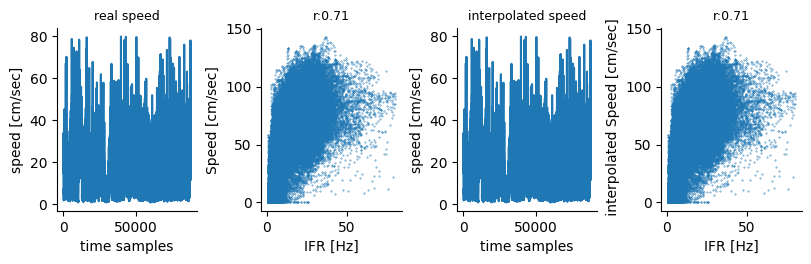

In [15]:
col = 4
row = 4
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


## load data from the session
fsCellList= cells[(~cells.gridCell_FIRST)& (cells.usable_auto_RF) & (cells.interneuron) & (cells.mrate_RF1> 10)]
cluId= fsCellList[fsCellList.session== sSes.name].cluId.iloc[10]
sSes,ses,n = get_sSesId_nId(cluId)
intervals= ses.intervalDict[interName]
pose_file_extension = ".pose.npy"
sSes.load_parameters_from_files()
ap = Animal_pose(sSes)
ap.pose_file_extension = pose_file_extension
ap.load_pose_from_file()
ap.unset_intervals()
ap.set_intervals(intervals)

ap.speed_from_pose(sigma=5)
ap.speed[ap.speed> 80]= np.nan


## get the ifr 
# trick to get aligned ifr and pose data
time = sSes.ap.pose[:,0]
bin_size_sec = np.diff(time)[0]
n.spike_train.set_intervals(intervals)
n.spike_train.instantaneous_firing_rate(bin_size_sec = bin_size_sec, sigma= sigma_ifr, time_start=min(time)-bin_size_sec/2, 
                                        time_end=max(time), outside_interval_solution="remove")
## keep the non Nans speeds
keepInd= ~(np.isnan(ap.speed))
speed= ap.speed[keepInd]
ifr= n.spike_train.ifr[0][keepInd]

#### Ploting 

ax= fig.add_subplot(gs[0])
ax.plot(speed)
ax.set_title('real speed', fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('time samples')
ax.set_ylabel('speed [cm/sec]')

ax= fig.add_subplot(gs[1])
ax.scatter( speed,ifr, s= 0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('IFR [Hz]')
ax.set_ylabel('Speed [cm/sec]')
r,p= pearsonr(ifr, speed)
ax.set_title(f'r:{r:.2f}', fontsize= 9)

### calculating the speed with Gingjies func 

sSes.ap.speed_from_pose(sigma=1)
speedProfile = sSes.ap.speed

# Filter for indicies where speed is too high
indicies = speedProfile > 80
sSes.ap.pose[indicies,1] = np.nan
sSes.ap.pose[indicies,2] = np.nan
animal_pose_pose_interpolate_small_gaps(sSes)
sSes.ap.speed_from_pose(sigma=5)

## keep the non Nans speeds
keepInd= ~(np.isnan(ap.speed))
speed= ap.speed[keepInd]
ifr= n.spike_train.ifr[0][keepInd]

ax= fig.add_subplot(gs[2])
ax.plot(speed)
ax.set_title('interpolated speed', fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('time samples')
ax.set_ylabel('speed [cm/sec]')

ax= fig.add_subplot(gs[3])
ax.scatter(speed,ifr, s= 0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('IFR [Hz]')
ax.set_ylabel(' interpolated Speed [cm/sec]')
r,p= pearsonr(ifr, speed)
ax.set_title(f'r:{r:.2f}', fontsize= 9)

## Make a pdf for all the cells to get the correlation between the ifr and other variables 

In [89]:
fn = myProject.dataPath+"/results/myMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    print('loading',fn)
    myMaps = pickle.load(handle)

loading /adata/projects/autopi_inter//results/myMaps.pickle


In [16]:
def plotmap(axes, im):

    axes.imshow(im.T,origin="lower",cmap='jet',interpolation=None)
    axes.set_title(f'circ80_1 \n {np.round(np.nanmax(im),2)} Hz',pad=3,y=0.99, fontsize=9)
    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])

In [17]:
gridCellList= cells[(cells.gridCell_FIRST)& (cells.usable_auto_RF)]
fsCellList= cells[(~cells.gridCell_FIRST)& (cells.usable_auto_RF) & (cells.interneuron) & (cells.mrate_RF1> 10)]


In [18]:
def plot_oneCell_ifr_correlatoins(gs,cells, cluId, sigma_speed= 5, sigma_ifr= 5):
    
    ax= fig.add_subplot(gs[0])
    ind = cells[cells.cluId == cluId].index[0]
    im= myMaps["circ80_1"][ind, 0:-1, 0:-1]
    plotmap(ax, im)

    intervals= ses.intervalDict[interName]
    ifr, pose, speed, time, mvt, magnitude = get_oneCell_ifr_for_model(cluId,cells,intervals, sigma_speed= sigma_speed, sigma_ifr= sigma_ifr )


    ax= fig.add_subplot(gs[1])
    ax.scatter(mvt[:,0].T,ifr[:-1], alpha= 0.01)
    r,p= pearsonr(mvt[:,0].T, ifr[:-1])
    ax.set_title(f'r:{r:.2f} \n clu:{cluId}', fontsize= 9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('unit vector x')
    ax.set_ylabel('ifr [Hz]')

    ax= fig.add_subplot(gs[2])
    ax.scatter(mvt[:,1].T,ifr[:-1], alpha= 0.01)
    r,p= pearsonr(mvt[:,1].T, ifr[:-1])
    ax.set_title(f'r:{r:.2f}', fontsize= 9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('unit vector y')
    ax.set_ylabel('ifr [Hz]')

    ax= fig.add_subplot(gs[3])
    sns.kdeplot(speed,ifr)
    r,p = pearsonr(speed, ifr)
    ax.set_title(f'r:{r:.2f} \n sigmaSpeed:{sigma_speed} \n sigmaifr: {sigma_ifr} ', fontsize= 9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('speed [cm/sec]')
    ax.set_ylabel('ifr [Hz]')


In [19]:
ifr, pose, speed, time, mvt, magnitude = get_oneCell_ifr_for_model(cluId,cells,intervals, sigma_speed= sigma_speed, sigma_ifr= sigma_ifr )

In [51]:
ifr.shape, speed.shape, mvt.shape

((87568,), (87568,), (87567, 2))

/home/maryam/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


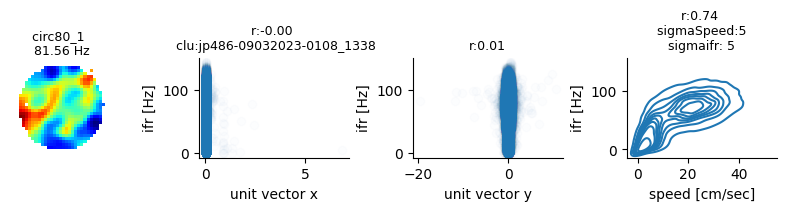

In [93]:
col = 4
row = 4
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

cluId= fsCellList[fsCellList.session== sSes.name].cluId.iloc[10]

gs3= gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0,:])#, width_ratios=[1.5,2,1,1])
plot_oneCell_ifr_correlatoins(gs3,cells, cluId, sigma_speed= 5, sigma_ifr= 5 )


We would need to have a sigma as the data is a bit noisy, I decided to put both the speed and the ifr sigma as 5. 

After talking with Gingjie, now we decide to remove the speeds above the 70 cm/sec and the positions related to that speed in the function get_speed_from_pose() in the Animal_pose.py in the spikeA package. 
and then interpolate the x and y in the same maner and regenerate the x and y. 

## Start working on the model 

Since we have a nonlinear relationship which is most likely sigmoidal relationship we are trying nonlinear models such as : 

1. Generalized Linear Model (GLM) with a Sigmoidal Link Function. A logistic regression or a generalized linear model (GLM) with a logistic or sigmoid activation function can model nonlinear relationships like a sigmoid curve. This would be a good starting point for modeling your sigmoidal relationship between ifr and speed.

2. Nonlinear Regression (Sigmoid Curve Fitting)

f(x)=1+e−(ax+b)1​

3. Decision Trees or Random Forests
Decision Trees or Random Forests can capture nonlinear relationships without explicitly needing to specify the form of the relationship. While they may not perfectly model a sigmoidal relationship, they can still be useful for prediction.

##  Generalized Linear Model (GLM)

In [20]:
from scipy.special import expit  # Sigmoid function
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error 


Split my data  and test the r value for another 20% where it was not even seen by the model: 

In [16]:
ses= myProject.sessionList[152]
sSes= sSessions[152]
ctype= 'fs'
interName = 'circ80_1'
sigma_speed= 5
sigma_ifr= 5



# Generate a func. for the GLM model 

In [22]:
def Get_speed_with_GLM_model_from_ifr(cluId,interName, sigma_speed= 5, sigma_ifr= 5):
    
    sSes,ses,n = get_sSesId_nId(cluId)
    trainingInter = ses.intervalDict[interName].copy()
    splitTime = np.ceil(trainingInter[0, 1] * 0.8)
    trainingInter[0, 1] = splitTime
    testInter = ses.intervalDict[interName].copy()
    testInter[0, 0] = splitTime

    ifr_train, pose_train, speed_train, time_train, mvt_train, magnitude_train = get_oneCell_ifr_for_model(cluId,cells,trainingInter, sigma_speed= sigma_speed, sigma_ifr= sigma_ifr)
    ifr_test, pose_test, speed_test, time_test, mvt_test, magnitude_train = get_oneCell_ifr_for_model(cluId,cells,testInter, sigma_speed= sigma_speed, sigma_ifr= sigma_ifr)

    # Create the GLM model with a logit link function (logistic regression / sigmoid)
    ifr_with_const_train = sm.add_constant(ifr_train)
    speed_train= np.array(speed_train)
    # Ensure shapes are correct
    print("Shape of ifr_with_const:", ifr_with_const_train.shape)  # Should be (6, 2)
    print("Shape of speed:", speed_train.shape)  # Should be (6,)

    # Create the GLM model with a Gaussian family (normal distribution) for regression
    model = sm.GLM(speed_train, ifr_with_const_train, family=sm.families.Gaussian())
    result = model.fit()

    # Predict the speed using the fitted model
    ifr_with_const_test = sm.add_constant(ifr_test)
    speed_test= np.array(speed_test)
    predicted_speed = result.predict(ifr_with_const_test)
    
    mse= mean_squared_error(speed_test,predicted_speed) 
   
    return speed_train, ifr_train, speed_test, ifr_test, predicted_speed, mse


Shape of ifr_with_const: (70097, 2)
Shape of speed: (70097,)


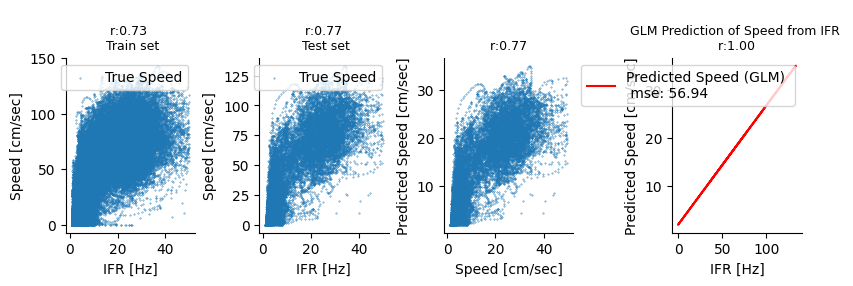

In [23]:
col = 4
row = 4
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


speed_train, ifr_train, speed_test, ifr_test, predicted_speed, mse = Get_speed_with_GLM_model_from_ifr(cluId,interName, sigma_speed= 5, sigma_ifr= 5)

ax= fig.add_subplot(gs[0,0])
plt.scatter( speed_train,ifr_train, label='True Speed', s= 0.1)
#plt.plot(ifr_test[0], predicted_speed, label='Predicted Speed (GLM)', color='red')
r,p= pearsonr(speed_train, ifr_train)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('IFR [Hz]')
ax.set_ylabel('Speed [cm/sec]')
ax.set_title(f'r:{r:.2f} \n Train set', fontsize= 9)
ax.legend()

ax= fig.add_subplot(gs[0,1])
plt.scatter(speed_test,ifr_test,  label='True Speed', s= 0.1)
#plt.plot(ifr_test[0], predicted_speed, label='Predicted Speed (GLM)', color='red')
r,p= pearsonr(speed_test, ifr_test)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('IFR [Hz]')
ax.set_ylabel('Speed [cm/sec]')
ax.set_title(f' \n r:{r:.2f} \n Test set', fontsize= 9)
ax.legend()


ax= fig.add_subplot(gs[0,2])
plt.scatter(speed_test, predicted_speed, s= 0.1)
#plt.plot(ifr_test[0], predicted_speed, label='Predicted Speed (GLM)', color='red')
r,p= pearsonr(predicted_speed, speed_test)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Speed [cm/sec]')
ax.set_ylabel('Predicted Speed [cm/sec]')
ax.set_title(f' \n r:{r:.2f} ', fontsize= 9)


ax= fig.add_subplot(gs[0,3])
#plt.scatter(ifr_test, predicted_speed, s= 0.1)
plt.plot(ifr_test, predicted_speed, label=f'Predicted Speed (GLM) \n mse: {mse:.2f}', color='red')
r,p= pearsonr(predicted_speed, ifr_test)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('IFR [Hz]')
ax.set_ylabel('Predicted Speed [cm/sec]')
ax.set_title(f'GLM Prediction of Speed from IFR \n r:{r:.2f} ', fontsize= 9)
ax.legend()


## 2. Use a Non-linear Regression Model

such as Random Forest Regression

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [ ]:
## split with pose and ifr 

In [25]:
def Get_speed_with_RandomForestRegressor_from_ifr_oneCell(cluId,interName, sigma_speed= 5, sigma_ifr= 5 ):
    
    sSes,ses,n = get_sSesId_nId(cluId)
    #trainingInter = ses.intervalDict[interName].copy()
    #splitTime = np.ceil(trainingInter[0, 1] * 0.8)
    #trainingInter[0, 1] = splitTime
    #testInter = ses.intervalDict[interName].copy()
    #testInter[0, 0] = splitTime
    
    #ifr_train, pose_train, speed_train, time_train, mvt_train, magnitude_train = get_oneCell_ifr_for_model(cluId,cells,trainingInter, sigma_speed= sigma_speed, sigma_ifr= sigma_ifr)
    #ifr_test, pose_test, speed_test, time_test, mvt_test, magnitude_train = get_oneCell_ifr_for_model(cluId,cells,testInter, sigma_speed= sigma_speed, sigma_ifr= sigma_ifr)
    intervals= ses.intervalDict[interName]
    ifr, pose, speed, time, mvt, magnitude = get_oneCell_ifr_for_model(cluId,cells,intervals, sigma_speed= sigma_speed, sigma_ifr= sigma_ifr)
    ifr_train, ifr_test, speed_train, speed_test = train_test_split(ifr, speed, test_size=0.2, random_state=42)
    
    # Reshape ifr arrays to be 2D (n_samples, n_features)
    ifr_train = ifr_train.reshape(-1, 1)
    ifr_test = ifr_test.reshape(-1, 1)

    # Initialize and train the RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(ifr_train, speed_train)

    ## get the speed predicted for the test set 
    # Predict the speeds
    predicted_speeds_rf = rf_model.predict(ifr_test)

    # Evaluate the model
    mse_rf = mean_squared_error(speed_test, predicted_speeds_rf)
    print(f'Mean Squared Error (Random Forest): {mse_rf}')

   
    return speed_train, ifr_train, speed_test, ifr_test, predicted_speeds_rf, mse_rf, rf_model


In [26]:
def Plot_modeling_data_oneCell(gs, cluId, speed_train, ifr_train, speed_test, ifr_test, predicted_speed, mse_rf,interName, modelType= 'RandomForestRegressor'):

    ax= fig.add_subplot(gs[0,0])
    ax.scatter(speed_train,ifr_train, label='Speed', s= 0.1)
    ifr_train_flat = ifr_train.ravel()  # or array2.reshape(-1)
    r,p= pearsonr(speed_train, ifr_train_flat)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('IFR [Hz]')
    ax.set_ylabel('Speed [cm/sec]')
    ax.set_title(f'clu: {cluId}\n r:{r:.2f} \n Train set \n {interName}', fontsize= 9)

    ax= fig.add_subplot(gs[0,1])
    plt.scatter(speed_test,ifr_test, label='Speed', s= 0.1)
    ifr_test_flat = ifr_test.ravel()  # or array2.reshape(-1)
    r,p= pearsonr(speed_test, ifr_test_flat)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('IFR [Hz]')
    ax.set_ylabel('Speed [cm/sec]')
    ax.set_title(f' \n r:{r:.2f} \n Test set', fontsize= 9)


    ax= fig.add_subplot(gs[0,2])
    plt.scatter(predicted_speed,speed_test, s= 0.1)
    #plt.plot(ifr_test[0], predicted_speed, label='Predicted Speed (GLM)', color='red')
    r,p= pearsonr(predicted_speed, speed_test)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Speed [cm/sec]')
    ax.set_ylabel('Predicted Speed [cm/sec]')
    ax.set_title(f' \n r:{r:.2f} ', fontsize= 9)


    ax= fig.add_subplot(gs[0,3])
    #plt.scatter(ifr_test, predicted_speed, s= 0.1)
    plt.scatter(predicted_speed,ifr_test, label=modelType, s= 0.1)
    r,p= pearsonr(predicted_speed, ifr_test_flat)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('IFR [Hz]')
    ax.set_ylabel('Predicted Speed [cm/sec]')
    ax.set_title(f'{modelType} Prediction \n of Speed from IFR \n r:{r:.2f} \n mse:{mse_rf:.2f} ', fontsize= 9)


Mean Squared Error (Random Forest): 79.75599532315783


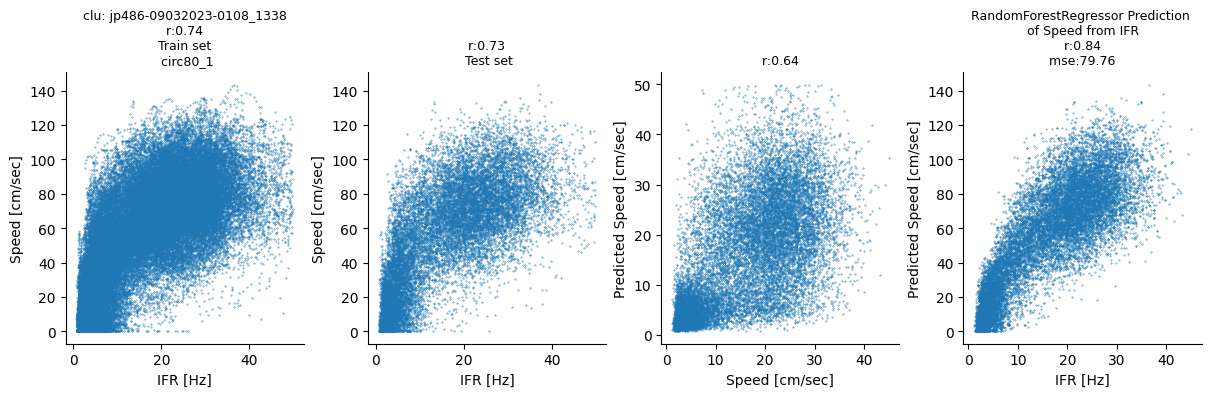

In [27]:
col = 4
row = 4
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

interName= 'circ80_1'
cluId= fsCellList[fsCellList.session== sSes.name].cluId.iloc[10]
speed_train, ifr_train, speed_test, ifr_test, predicted_speed, mse_rf, rf_model = Get_speed_with_RandomForestRegressor_from_ifr_oneCell(cluId,interName, sigma_speed= 5, sigma_ifr= 5)
Plot_modeling_data_oneCell(gs, cluId, speed_train, ifr_train, speed_test, ifr_test, predicted_speed, mse_rf, interName, modelType= 'RandomForestRegressor')

Mean square error: 

MSE=n1​i=1∑n​(yi​−yi​^​)

How close is the predicted value to the real value that we are predicting .. 

Lower mes is better since its also closer to the range of the speed that we have as an input (we have speeds from 0-50 cm/sec)

now we try to add the data from multiple cells to check if the MES reduces 

## Get the ifr from multiple interneurons

In [154]:
def Get_speed_with_RandomForestRegressor_from_ifr_oneSession(sSes, interName, sigma_speed= 5, sigma_ifr= 5): 
    intervals= ses.intervalDict[interName]
    ifr, pose, speed, time, mvt, magnitude = get_session_ifr_for_model(sSes.name,cells,sSessions,intervals,ctype= 'fs', sigma_speed= sigma_speed, sigma_ifr= sigma_ifr)
    
    if np.isnan(ifr).any(): 
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    else: 
        ifr = ifr.T  # Now shape is (70096, 14)
        ifr_train, ifr_test, speed_train, speed_test = train_test_split(ifr, speed, test_size=0.2, random_state=42)

        # Initialize and train the RandomForestRegressor
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(ifr_train, speed_train)

        # Make predictions
        speed_pred = model.predict(ifr_test)
        # Evaluate the model
        mse = mean_squared_error(speed_test, speed_pred)
        print(f"Mean Squared Error: {mse}")

        r_squared = model.score(ifr_test, speed_test)

    return ifr_train, ifr_test, speed_train, speed_test, speed_pred, mse, r_squared, model

def Plot_modeling_data_oneSession(gs, ifr_train, ifr_test, speed_train, speed_test, speed_pred, mse, interName,r_squared, modelType= 'RF_model_(rfr)'):

    ax= fig.add_subplot(gs[0,0])
    ax.scatter(speed_train, ifr_train.mean(axis=1), label='Speed', s= 0.1)
    #plt.plot(ifr_test[0], predicted_speed, label='Predicted Speed (GLM)', color='red')
    r,p= pearsonr(speed_train, ifr_train.mean(axis=1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Mean IFR [Hz]')
    ax.set_ylabel('Speed [cm/sec]')
    ax.set_title(f'n: {ifr_train.shape[1]}\n r:{r:.2f} \n Train set \n {interName}', fontsize= 9)

    ax= fig.add_subplot(gs[0,1])
    plt.scatter(speed_test,ifr_test.mean(axis=1), label='Speed', s= 0.1)
    #plt.plot(ifr_test[0], predicted_speed, label='Predicted Speed (GLM)', color='red')
    r,p= pearsonr(speed_test, ifr_test.mean(axis=1))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Mean IFR [Hz]')
    ax.set_ylabel('Speed [cm/sec]')
    ax.set_title(f' \n r:{r:.2f} \n Test set \n {interName}', fontsize= 9)

    ax= fig.add_subplot(gs[0,2])
    plt.scatter( speed_pred,speed_test, s= 0.1)
    #plt.plot(ifr_test[0], predicted_speed, label='Predicted Speed (GLM)', color='red')
    r,p= pearsonr(speed_pred, speed_test)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Speed [cm/sec]')
    ax.set_ylabel('Predicted Speed [cm/sec]')
    ax.set_title(f' \n r:{r:.2f} ', fontsize= 9)

    ax= fig.add_subplot(gs[0,3])
    #plt.scatter(ifr_test, predicted_speed, s= 0.1)
    plt.scatter( speed_pred,ifr_test.mean(axis=1), label=modelType, s= 0.1)
    r,p= pearsonr(speed_pred, ifr_test.mean(axis=1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(' Mean IFR [Hz]')
    ax.set_ylabel('Predicted Speed [cm/sec]')
    ax.set_title(f'{modelType} \n of Pred_Speed from IFR \n r:{r:.2f} \n mse:{mse:.2f} \n r2:{r_squared:.2f}', fontsize= 9)


Mean Squared Error (Random Forest): 79.75599532315783
Mean Squared Error: 9.525937421414886


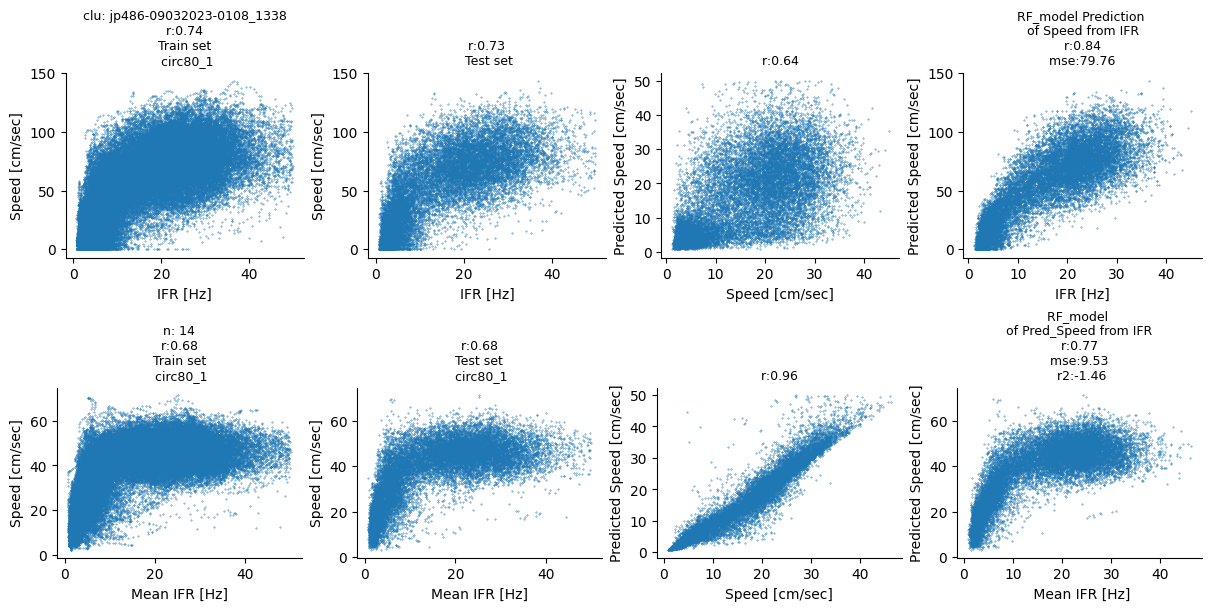

In [384]:
col = 4
row = 4
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


### single cell input for the ifr 
cluId= fsCellList[fsCellList.session== sSes.name].cluId.iloc[10]
gs0= gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0,:])#, width_ratios=[1.5,2,1,1])

speed_train, ifr_train, speed_test, ifr_test, predicted_speed, mse_rf, rf_model = Get_speed_with_RandomForestRegressor_from_ifr_oneCell(cluId,interName= 'circ80_1', sigma_speed= 5, sigma_ifr= 5)
Plot_modeling_data_oneCell(gs0, cluId, speed_train, ifr_train, speed_test, ifr_test, predicted_speed, mse_rf, interName, modelType= 'RF_model')


### multiple cells as an input for IFR
gs1= gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1,:])#, width_ratios=[1.5,2,1,1])
ifr_train, ifr_test, speed_train, speed_test, speed_pred, mse, r_squared, model = Get_speed_with_RandomForestRegressor_from_ifr_oneSession(sSes, interName= 'circ80_1', sigma_speed= 5, sigma_ifr= 5)
Plot_modeling_data_oneSession(gs1, ifr_train, ifr_test, speed_train, speed_test, speed_pred, mse,interName,r_squared, modelType= 'RF_model')


It seems that more number of te cells would drastically reduce the mse and the pattern of the data looks more sigmoidal than if we have ifr from single cell  

In [385]:
ses.intervalDict.keys()

dict_keys(['circ80', 'circ80_1', 'circ80_2', 'task', 'task_1', 'task_2', 'light', 'light_1', 'light_2', 'dark', 'dark_1', 'dark_2', 'trialNo', 'searchPath_light', 'searchPath_light_1', 'searchPath_light_2', 'searchPath_dark', 'searchPath_dark_1', 'searchPath_dark_2', 'searchToLeverPath_light', 'searchToLeverPath_light_1', 'searchToLeverPath_light_2', 'searchToLeverPath_dark', 'searchToLeverPath_dark_1', 'searchToLeverPath_dark_2', 'homingPath_light', 'homingPath_light_1', 'homingPath_light_2', 'homingPath_dark', 'homingPath_dark_1', 'homingPath_dark_2', 'homingFromLeavingLever_light', 'homingFromLeavingLever_light_1', 'homingFromLeavingLever_light_2', 'homingFromLeavingLever_dark', 'homingFromLeavingLever_dark_1', 'homingFromLeavingLever_dark_2', 'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_light_1', 'homingFromLeavingLeverToPeriphery_light_2', 'homingFromLeavingLeverToPeriphery_dark', 'homingFromLeavingLeverToPeriphery_dark_1', 'homingFromLeavingLeverT

## Need to use the model that I generate during the RF to predict the speed in the task 

To measure how well this model is working we use the MSE and r_square and the sigmoidal function fitting : 

1. MSE

Mean square error: 

MSE=n1​i=1∑n​(yi​−yi​^​)

How close is the predicted value to the real value that we are predicting .. 

2. To calculate the R-squared (coefficient of determination) in this case:
R2=1−Sum of squared residuals (SSR)Total sum of squares (SST)
R2=1−Total sum of squares (SST)Sum of squared residuals (SSR)​

Where:

    SSR is the sum of the squared differences between the actual speed and the predicted speed.
    SST is the sum of the squared differences between the actual speed and the mean of the actual speeds.
    
3.  Assess the Steepness or "Sigmoidality": 
Sigmoid Function Fitting (Logistic Function Fit)

One way to assess the sigmoidality of your data is to fit a sigmoid function (e.g., a logistic function) and then examine its steepness and inflection point. The logistic function can be expressed as:
y=L1+e−k(x−x0)
y=1+e−k(x−x0​)L​

Where:

    LL is the curve's maximum value (upper asymptote).
    x0x0​ is the value of the sigmoid's midpoint (inflection point).
    kk is the steepness (the rate of growth around the inflection point).

The parameter kk gives a direct measure of steepness. You can fit this function to your data using scipy.optimize.curve_fit:


In [33]:
def Fit_RFModel_toIntervals_oneSession(sSes, interName, model_RF, sigma_speed= 5, sigma_ifr= 5):
    
    #interName= 'light'
    intervals= ses.intervalDict[interName]
    ifr, pose, speed, time, mvt, magnitude = get_session_ifr_for_model(sSes.name,cells,sSessions,intervals,ctype= 'fs', sigma_speed= sigma_speed, sigma_ifr= sigma_ifr)
    ifr = ifr.T  # Now shape is (70096, 14)
    ifr_train, ifr_test, speed_train, speed_test = train_test_split(ifr, speed, test_size=0.2, random_state=42)
    model_RF.fit(ifr_train, speed_train)

    # Make predictions
    speed_pred = model_RF.predict(ifr_test)
    mse = mean_squared_error(speed_test, speed_pred)
    ## calculate the R_square how well the ifr_fits to speed
    r_squared = model_RF.score(ifr_test, speed_test)
    print(f"Mean Squared Error: {mse}")
    

    return ifr_train, ifr_test, speed_train, speed_test, speed_pred, mse, r_squared



Mean Squared Error: 9.525937421414886
Mean Squared Error: 9.525937421414886
Mean Squared Error: 13.155838667294093
Mean Squared Error: 9.856425236620618


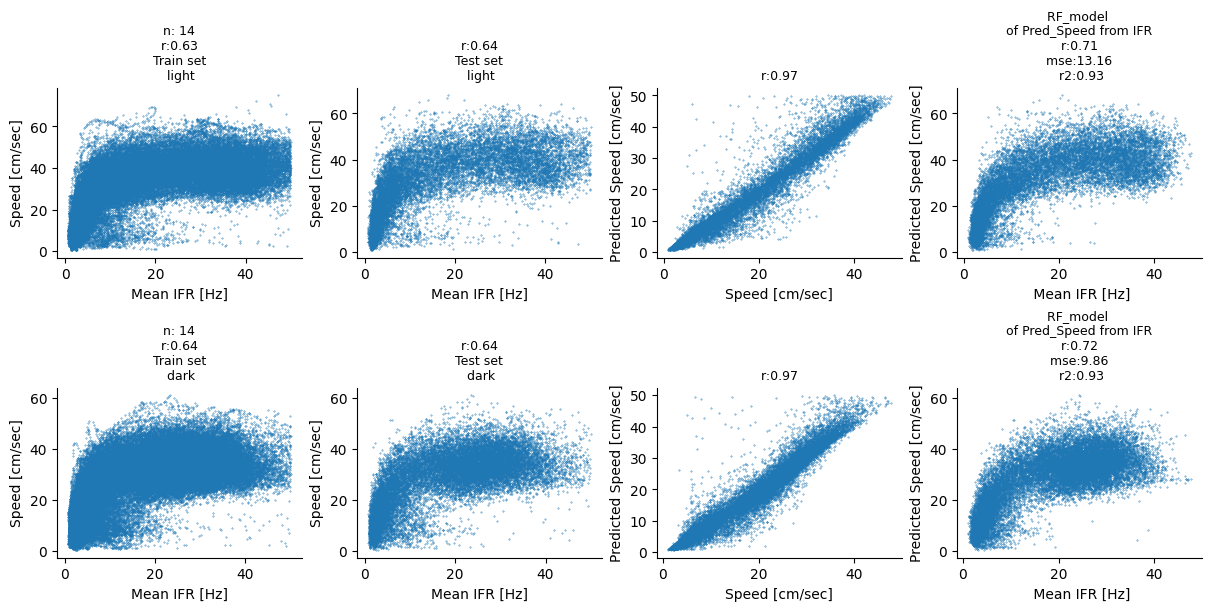

In [34]:
col = 4
row = 4
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

### 
ifr_train_RF, ifr_test_RF, speed_train_RF, speed_test_RF, speed_pred_RF, mse_RF,r_squared_RF, model_RF = Get_speed_with_RandomForestRegressor_from_ifr_oneSession(sSes, interName= 'circ80_1', sigma_speed= 5, sigma_ifr= 5)

gs2= gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1,:])#, width_ratios=[1.5,2,1,1])
ifr_train_RF, ifr_test_RF, speed_train_RF, speed_test_RF, speed_pred_RF, mse_RF,r_squared_RF, model_RF = Get_speed_with_RandomForestRegressor_from_ifr_oneSession(sSes, interName= 'circ80_1', sigma_speed= 5, sigma_ifr= 5)
ifr_train_light, ifr_test_light, speed_train_light, speed_test_light, speed_pred_light, mse_light, r_squared_light = Fit_RFModel_toIntervals_oneSession(sSes, interName= 'light', model_RF= model_RF , sigma_speed= 5, sigma_ifr= 5)
Plot_modeling_data_oneSession(gs2, ifr_train_light, ifr_test_light, speed_train_light, speed_test_light, speed_pred_light, mse_light,interName= 'light', r_squared= r_squared_light, modelType= 'RF_model')

gs3= gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[2,:])#, width_ratios=[1.5,2,1,1])
ifr_train_dark, ifr_test_dark, speed_train_dark, speed_test_dark, speed_pred_dark, mse_dark, r_squared_dark = Fit_RFModel_toIntervals_oneSession(sSes, interName= 'dark', model_RF= model_RF, sigma_speed= 5, sigma_ifr= 5)
Plot_modeling_data_oneSession(gs3, ifr_train_dark, ifr_test_dark, speed_train_dark, speed_test_dark, speed_pred_dark, mse_dark,interName= 'dark',r_squared= r_squared_dark, modelType= 'RF_model')


Run the model from RF to other internames and save the mse and the pred_speed ans test_speed from each interval to compare later 

In [35]:
interNames= ['searchToLeverPath_light', 'searchToLeverPath_dark', 'homingFromLeavingLever_light',  'homingFromLeavingLever_dark', 'atLever_dark', 'atLever_light']
labs=['SL', 'SD', 'HL', 'HD', 'atLeverL', 'atLeverD']

ifr_train_RF, ifr_test_RF, speed_train_RF, speed_test_RF, speed_pred_RF, mse_RF,r_squared_RF, model_RF = Get_speed_with_RandomForestRegressor_from_ifr_oneSession(sSes, interName= 'circ80_1', sigma_speed= 5, sigma_ifr= 5)

results_dict = {}

for interName in tqdm(interNames):
    # Run the model for each interval
    ifr_train, ifr_test, speed_train, speed_test, speed_pred, mse, r_squared = Fit_RFModel_toIntervals_oneSession(
        sSes, interName, model_RF, sigma_speed=sigma_speed, sigma_ifr=sigma_ifr
    )

    # Save results in dictionary with interval name as key
    results_dict[interName] = {
        'nfs': ifr_train.shape[1],
        'ifr_train': ifr_train,
        'ifr_test': ifr_test,
        'speed_train': speed_train,
        'speed_test': speed_test,
        'speed_pred': speed_pred,
        'mse': mse, 
        'R2': r_squared
        
    }
dfres= pd.DataFrame(results_dict)

Mean Squared Error: 9.525937421414886


 17%|███████▌                                     | 1/6 [00:21<01:49, 21.93s/it]

Mean Squared Error: 13.141121551459001


 33%|███████████████                              | 2/6 [00:55<01:55, 28.85s/it]

Mean Squared Error: 8.416003119955656


 50%|██████████████████████▌                      | 3/6 [01:16<01:15, 25.07s/it]

Mean Squared Error: 22.541626653187528


 67%|██████████████████████████████               | 4/6 [01:39<00:48, 24.21s/it]

Mean Squared Error: 12.655078019964316


 83%|█████████████████████████████████████▌       | 5/6 [02:03<00:24, 24.25s/it]

Mean Squared Error: 13.482103314911884


100%|█████████████████████████████████████████████| 6/6 [02:26<00:00, 24.44s/it]

Mean Squared Error: 14.144833980092717


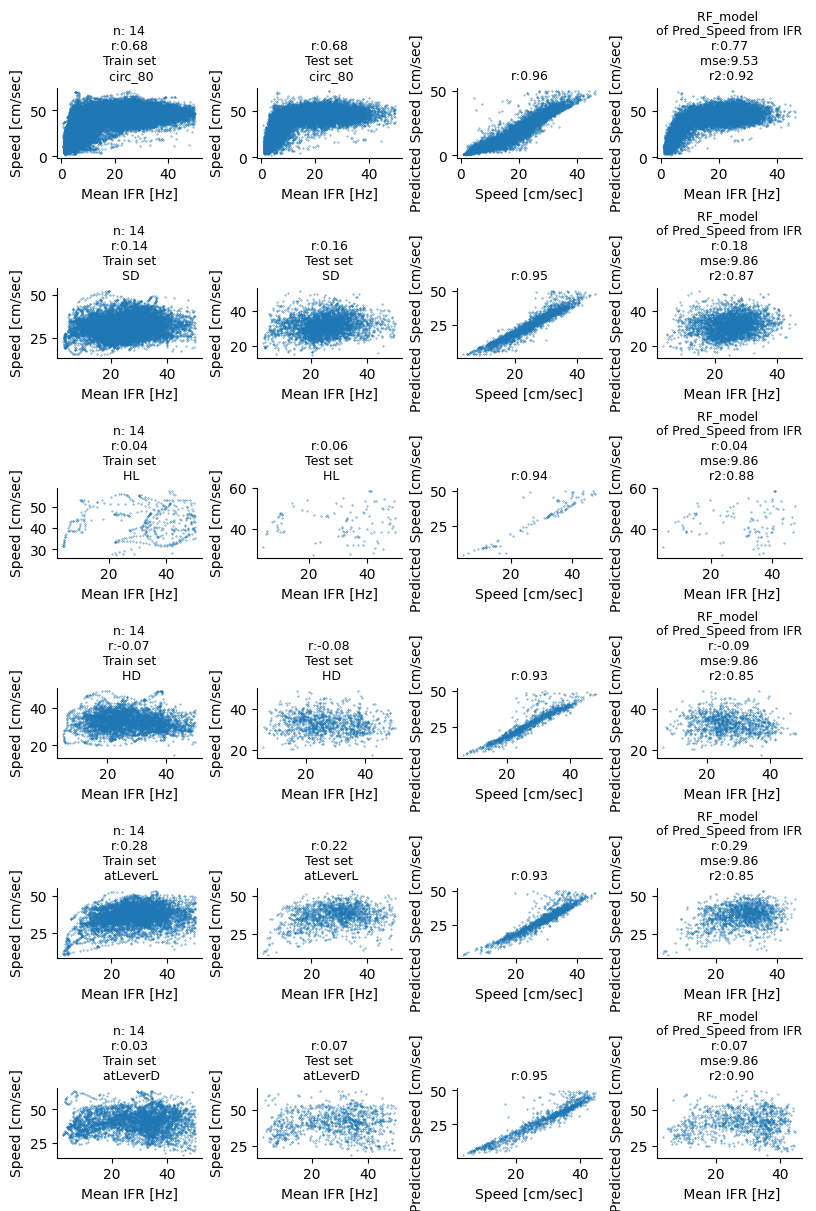

In [36]:
col = 4
row = len(results_dict.keys()) +1 
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)
labs=['SL', 'SD', 'HL', 'HD', 'atLeverL', 'atLeverD']


for i, (inter, lab)  in enumerate(zip(results_dict.keys(), labs)):
   

    ifr_train = results_dict[inter]['ifr_train']
    speed_train= results_dict[inter]['speed_train']
    ifr_test = results_dict[inter]['ifr_test']
    speed_test= results_dict[inter]['speed_test']
    speed_pred= results_dict[inter]['speed_pred']
    mse= results_dict[inter]['mse']
    R2= results_dict[inter]['R2']

    gsi= gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[i,:])
    if i == 0: 
         ## Plot the model in the RF 
        Plot_modeling_data_oneSession(gsi, ifr_train_RF, ifr_test_RF, speed_train_RF, speed_test_RF, speed_pred_RF, mse_RF,interName= 'circ_80', r_squared= r_squared_RF, modelType= 'RF_model')
    else: 
        Plot_modeling_data_oneSession(gsi, ifr_train, ifr_test, speed_train, speed_test, speed_pred, mse_dark,interName= lab,r_squared= R2, modelType= 'RF_model')

fig.savefig('Predict_one_session_speed.png', dpi= 300)

In [37]:
results_dict.keys()

dict_keys(['searchToLeverPath_light', 'searchToLeverPath_dark', 'homingFromLeavingLever_light', 'homingFromLeavingLever_dark', 'atLever_dark', 'atLever_light'])

## Run the randomForest model on all the sessions and get the mse and the correlation between the speed and predicted speed for all the sessions for all trials, 
The aim is to find out 

1. How many FS interneurons do we need to have that this model works ? Is it True for all the sessions?
2. in with Interval we can predict the speed of the animal with a better accuracy than from the model that we trained in the RF trials

Generate a func to save the model and relevant inf to a dict. or df 

1. we need to have a r values between the seed and predicted speed 

(0, 41)

In [ ]:
sigma_speed= 5; sigma_ifr= 5
interNames= ['searchToLeverPath_light', 'searchToLeverPath_dark', 'homingFromLeavingLever_light',  'homingFromLeavingLever_dark', 'atLever_dark', 'atLever_light']
#labs=['SL', 'SD', 'HL', 'HD', 'atLeverL', 'atLeverD']
dfs = []  # List to hold DataFrames from each session

# Loop through sessions
for sSes in tqdm(sSessions): 
    # Filter cells based on criteria
    nfs = cells[(cells.session == sSes.name) & (cells.interneuron) & (cells.mrate_RF1 > 10)].shape[0]
    
    if nfs != 0:
        # Run RandomForest on 'circ80_1' interval
        ifr_train_RF, ifr_test_RF, speed_train_RF, speed_test_RF, speed_pred_RF, mse_RF, r_squared_RF, model_RF = \
            Get_speed_with_RandomForestRegressor_from_ifr_oneSession(sSes, interName='circ80_1', sigma_speed=sigma_speed, sigma_ifr=sigma_ifr)

        # Dictionary to collect results for each interval
        results = []

        for interName in interNames:
            # Run the model on each interval
            ifr_train, ifr_test, speed_train, speed_test, speed_pred, mse, r_squared = Fit_RFModel_toIntervals_oneSession(
                sSes, interName, model_RF, sigma_speed=sigma_speed, sigma_ifr=sigma_ifr
            )

            # Collect results into a dictionary for this session and interval
            results.append({
                'session': sSes.name,
                'interval': interName,
                'nfs': ifr_train.shape[1],  # assuming this gives number of features
                'mse': mse,
                'R2': r_squared,
                'speed_test': speed_test,  # Optional: Store any additional metrics if useful
                'speed_pred': speed_pred
            })

        # Convert results to DataFrame and append to the list
        dfres = pd.DataFrame(results)
        dfs.append(dfres)

In [161]:
len(dfs)

153

In [162]:
final_df = pd.concat(dfs, ignore_index=True)

In [163]:
final_df

,session,interval,nfs,mse,R2,speed_test,speed_pred
0,mn8578-05122021-0108,searchToLeverPath_light,1,182.956827,-0.379794,"[5.805390205081972, 30.75728900106473, 0.77094...","[5.8737120402752865, 8.193505960658506, 21.600..."
1,mn8578-05122021-0108,searchToLeverPath_dark,1,136.998305,-0.096697,"[39.69639228481159, 25.861104415302066, 13.603...","[17.089052847152672, 8.473442254919117, 13.160..."
2,mn8578-05122021-0108,homingFromLeavingLever_light,1,188.480676,-0.249789,"[17.439247597342, 9.177271660596718, 5.8292897...","[14.151870265277806, 17.895045230964463, 10.26..."
3,mn8578-05122021-0108,homingFromLeavingLever_dark,1,166.318763,-0.373683,"[14.257299007721512, 21.483362082057894, 2.117...","[8.153233470285047, 19.677034484325006, 11.042..."
4,mn8578-05122021-0108,atLever_dark,1,194.172941,-0.340351,"[37.597326359556455, 10.046417303283109, 49.47...","[3.315994138856742, 30.668333058356403, 3.4502..."
...,...,...,...,...,...,...,...
913,jp499-25052023-0108,searchToLeverPath_dark,5,21.889669,0.777647,"[1.2171649641921451, 16.670369451923264, 3.233...","[1.5946746383358958, 8.656533285531783, 5.3104..."
914,jp499-25052023-0108,homingFromLeavingLever_light,5,70.734213,0.666822,"[43.81342288165051, 2.286308095528461, 10.5792...","[27.909323496913284, 4.812611038891879, 8.3495..."
915,jp499-25052023-0108,homingFromLeavingLever_dark,5,26.762855,0.778820,"[7.523842756059783, 8.366462065039887, 2.77753...","[7.2837483496541084, 10.049730850310755, 3.048..."
916,jp499-25052023-0108,atLever_dark,5,25.358497,0.731263,"[0.2997540252959049, 0.5178092330329844, 3.071...","[0.7749372836241578, 3.0646359388151057, 2.680..."


In [167]:
type(final_df.speed_pred.iloc[0]), final_df.keys()

(numpy.ndarray,
 Index(['session', 'interval', 'nfs', 'mse', 'R2', 'speed_test', 'speed_pred'], dtype='object'))

In [168]:
# Initialize an empty list to store the Pearson correlations
r_values = []

# Loop through each row of the DataFrame
for index, row in final_df.iterrows():
    # Get speed_test and speed_pred for the current row
    speed_test = row['speed_test']
    speed_pred = row['speed_pred']
    
    # Calculate the Pearson correlation coefficient (r)
    r, _ = pearsonr(speed_test, speed_pred)
    
    # Append the result to the r_values list
    r_values.append(r)

# Add the r_values as a new column to the DataFrame
final_df['r'] = r_values

In [169]:
final_df

,session,interval,nfs,mse,R2,speed_test,speed_pred,r
0,mn8578-05122021-0108,searchToLeverPath_light,1,182.956827,-0.379794,"[5.805390205081972, 30.75728900106473, 0.77094...","[5.8737120402752865, 8.193505960658506, 21.600...",0.111757
1,mn8578-05122021-0108,searchToLeverPath_dark,1,136.998305,-0.096697,"[39.69639228481159, 25.861104415302066, 13.603...","[17.089052847152672, 8.473442254919117, 13.160...",0.309799
2,mn8578-05122021-0108,homingFromLeavingLever_light,1,188.480676,-0.249789,"[17.439247597342, 9.177271660596718, 5.8292897...","[14.151870265277806, 17.895045230964463, 10.26...",0.149484
3,mn8578-05122021-0108,homingFromLeavingLever_dark,1,166.318763,-0.373683,"[14.257299007721512, 21.483362082057894, 2.117...","[8.153233470285047, 19.677034484325006, 11.042...",0.125068
4,mn8578-05122021-0108,atLever_dark,1,194.172941,-0.340351,"[37.597326359556455, 10.046417303283109, 49.47...","[3.315994138856742, 30.668333058356403, 3.4502...",0.078035
...,...,...,...,...,...,...,...,...
913,jp499-25052023-0108,searchToLeverPath_dark,5,21.889669,0.777647,"[1.2171649641921451, 16.670369451923264, 3.233...","[1.5946746383358958, 8.656533285531783, 5.3104...",0.889288
914,jp499-25052023-0108,homingFromLeavingLever_light,5,70.734213,0.666822,"[43.81342288165051, 2.286308095528461, 10.5792...","[27.909323496913284, 4.812611038891879, 8.3495...",0.821771
915,jp499-25052023-0108,homingFromLeavingLever_dark,5,26.762855,0.778820,"[7.523842756059783, 8.366462065039887, 2.77753...","[7.2837483496541084, 10.049730850310755, 3.048...",0.885836
916,jp499-25052023-0108,atLever_dark,5,25.358497,0.731263,"[0.2997540252959049, 0.5178092330329844, 3.071...","[0.7749372836241578, 3.0646359388151057, 2.680...",0.861761


In [173]:
## do the same but only for the RF trial : 

In [187]:
RFdfs=[]
for sSes in tqdm(sSessions): 
    # Filter cells based on criteria
    nfs = cells[(cells.session == sSes.name) & (cells.interneuron) & (cells.mrate_RF1 > 10)].shape[0]
    
    res=[]
    if nfs != 0:
        # Run RandomForest on 'circ80_1' interval
        ifr_train_RF, ifr_test_RF, speed_train_RF, speed_test_RF, speed_pred_RF, mse_RF, r_squared_RF, model_RF = \
            Get_speed_with_RandomForestRegressor_from_ifr_oneSession(sSes, interName='circ80_1', sigma_speed=sigma_speed, sigma_ifr=sigma_ifr)
        
        r, _ = pearsonr(speed_test_RF, speed_pred_RF) 
        
        # Collect results into a dictionary for this session and interval
        res.append({
            'session': sSes.name,
            'interval': 'circ80_1',
            'nfs': ifr_train_RF.shape[1],  # assuming this gives number of features
            'mse': mse_RF,
            'R2': r_squared_RF,
            'speed_test': speed_test_RF,  # Optional: Store any additional metrics if useful
            'speed_pred': speed_pred_RF, 
            'r':r 
        })

        # Convert results to DataFrame and append to the list
        dfRF = pd.DataFrame(res)
        RFdfs.append(dfRF)

In [188]:
df_RF = pd.concat(RFdfs)

In [189]:
df_RF.shape, len(RFdfs)

((153, 8), 153)

In [200]:
fn= 'RandomForest_model_ifr_speed.pkl'
final_df = pd.read_pickle(fn)

In [204]:
final_df= pd.concat([final_df,df_RF])

In [220]:
final_df.columns

fin

Index(['session', 'interval', 'nfs', 'mse', 'R2', 'speed_test', 'speed_pred',
       'r'],
      dtype='object')

[Text(0, 0, 'RF'),
 Text(1, 0, 'SL'),
 Text(2, 0, 'SD'),
 Text(3, 0, 'HL'),
 Text(4, 0, 'HD'),
 Text(5, 0, 'atLeverL'),
 Text(6, 0, 'atLeverD')]

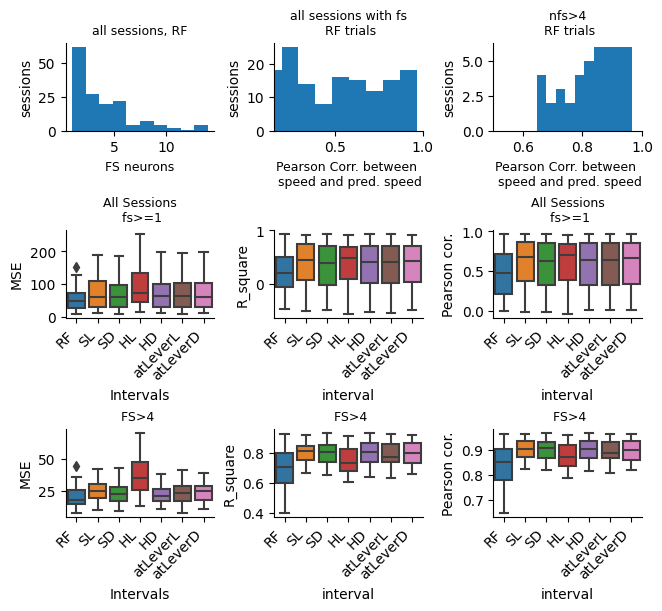

In [262]:
col = 4
row = 3 
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

ax= fig.add_subplot(gs[0,0])
ax.hist(final_df[final_df.interval=='circ80_1'].nfs)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('FS neurons',fontsize=9)
ax.set_ylabel('sessions')
ax.set_title(f' all sessions, RF ', fontsize= 9)


ax= fig.add_subplot(gs[0,1])
ax.hist(final_df[(final_df.interval=='circ80_1') & (final_df.nfs>0)].r)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Pearson Corr. between \n speed and pred. speed', fontsize=9)
ax.set_ylabel('sessions')
ax.set_xlim(0.15,1)
ax.set_title(f' all sessions with fs \n RF trials', fontsize= 9)

ax= fig.add_subplot(gs[0,2])
ax.hist(final_df[(final_df.interval=='circ80_1') & (final_df.nfs>4)].r)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Pearson Corr. between \n speed and pred. speed', fontsize=9)
ax.set_ylabel('sessions')
ax.set_xlim(0.5,1)
ax.set_title(f' nfs>4 \n RF trials', fontsize= 9)


##############
###############
ax= fig.add_subplot(gs[1,0])
order= [ 'circ80_1' ,'searchToLeverPath_light', 'searchToLeverPath_dark',
       'homingFromLeavingLever_light', 'homingFromLeavingLever_dark',
       'atLever_dark', 'atLever_light']

labs=['RF','SL', 'SD', 'HL', 'HD', 'atLeverL', 'atLeverD']

sns.boxplot(data=final_df, x='interval', y='mse', order=order)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Intervals')
ax.set_ylabel('MSE')
ax.set_title(f' All Sessions \n fs>=1', fontsize= 9)
ax.set_xticklabels(labs, rotation=45, ha='right')

ax= fig.add_subplot(gs[1,1])
order= [ 'circ80_1' ,'searchToLeverPath_light', 'searchToLeverPath_dark',
       'homingFromLeavingLever_light', 'homingFromLeavingLever_dark',
       'atLever_dark', 'atLever_light']

labs=['RF','SL', 'SD', 'HL', 'HD', 'atLeverL', 'atLeverD']

sns.boxplot(data=final_df, x='interval', y='R2', order=order)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('R_square')
ax.set_title(f' ', fontsize= 9)
ax.set_xticklabels(labs, rotation=45, ha='right')

ax= fig.add_subplot(gs[1,2])
order= [ 'circ80_1' ,'searchToLeverPath_light', 'searchToLeverPath_dark',
       'homingFromLeavingLever_light', 'homingFromLeavingLever_dark',
       'atLever_dark', 'atLever_light']

labs=['RF','SL', 'SD', 'HL', 'HD', 'atLeverL', 'atLeverD']

sns.boxplot(data=final_df, x='interval', y='r', order=order)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Pearson cor.')
ax.set_title(f' All Sessions \n fs>=1', fontsize= 9)
ax.set_xticklabels(labs, rotation=45, ha='right')


##############
##################
####
ax= fig.add_subplot(gs[2,0])
sns.boxplot(data=final_df[(final_df.nfs>4)], x='interval', y='mse', order=order)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Intervals')
ax.set_ylabel('MSE')
ax.set_title(f'FS>4 ', fontsize= 9)
ax.set_xticklabels(labs, rotation=45, ha='right')


ax= fig.add_subplot(gs[2,1])
sns.boxplot(data=final_df[(final_df.nfs>4)], x='interval', y='R2', order=order)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('R_square')
ax.set_title(f' FS>4', fontsize= 9)
ax.set_xticklabels(labs, rotation=45, ha='right')

ax= fig.add_subplot(gs[2,2])
sns.boxplot(data=final_df[(final_df.nfs>4)], x='interval', y='r', order=order)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Pearson cor.')
ax.set_title(f' FS>4', fontsize= 9)
ax.set_xticklabels(labs, rotation=45, ha='right')


In [259]:
# Step 1: Filter the DataFrame
FS = cells[(cells.interneuron) & (cells.mrate_RF1 > 10)]
interneuron_counts = FS.groupby('session').cluId.count()
sessions_counts= interneuron_counts[interneuron_counts > 4]

# Step 4: Count how many sessions meet the condition
num_sessions = len(sessions_counts)
print(f'Number of sessions with more than 4 FS: {num_sessions}')


Number of sessions with more than 4 FS: 44


Wth this model, I could predict the speed of the animal in all the intervals using only the ifr of FS cells in a session with more than 4 FS cells. 

Number of sessions that have more than 4 FS are 44. 

## Do we have sigmoidal relationship between the speed and IFR in all sessions  and in all inetervals? 


I used the polynomial and sigmoidal functions and didnt get a good fit and then later I tried the Hyperbolic (saturated) curve and get a good fit.
1. Hyperbolic (Saturation) Curve:

This function follows a form similar to:
y=axb+x
y=b+xax​

Where:

    aa represents the saturation value (maximum),
    bb controls how quickly the function saturates.

In [38]:
from scipy.optimize import curve_fit

In [39]:
def hyperbolic(x, a, b):
    return (a * x) / (b + x)


In [41]:
ses= myProject.sessionList[152]
sSes= sSessions[152]
interName= 'circ80_1'
sigma_speed= 5
sigma_ifr= 5

ifr, pose, speed, time, mvt, magnitude = get_session_ifr_for_model(sSes.name,cells,sSessions,intervals,ctype= 'fs', sigma_speed= sigma_speed, sigma_ifr= sigma_ifr)
meanifr = ifr.mean(axis=0)
ifr_flat = meanifr.flatten()
speed_flat = speed.flatten()


In [42]:
ifr.shape, 

((14, 87567),)

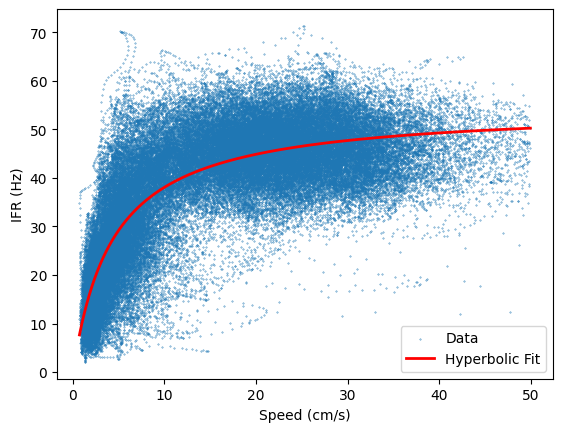

In [43]:
# Fit the hyperbolic model to your data
#popt, pcov = curve_fit(hyperbolic, speed, ifr_flat, p0=[max(ifr_flat), np.median(speed_flat)])
popt, pcov = curve_fit(hyperbolic, speed, meanifr, p0=[max(ifr_flat), np.median(speed_flat)])

# Extract fitted parameters
a, b = popt
speed_fit = np.linspace(min(speed_flat), max(speed_flat), 2000)
ifr_fit = hyperbolic(speed_fit, a, b)
# Plot the original data and the fitted curve
plt.scatter(speed_flat, ifr_flat, label='Data', s= 0.1)
plt.plot(speed_fit, ifr_fit, label='Hyperbolic Fit', color='red', lw= 2)
plt.xlabel('Speed (cm/s)')
plt.ylabel('IFR (Hz)')
plt.legend()


In [53]:
# Use the fitted model to predict IFR from speed
ifr_pred = hyperbolic(speed_flat, a, b)
r2_ifr = r2_score(ifr_flat, ifr_pred)

In [63]:
#popt, pcov = curve_fit(hyperbolic, speed, ifr_flat, p0=[max(ifr_flat), np.median(speed_flat)])
popt, pcov = curve_fit(hyperbolic, meanifr, speed , p0=[max(speed_flat), np.median(ifr_flat)])
a, b = popt

speed_pred = hyperbolic(ifr_flat, a, b)
r2_speed = r2_score(speed_flat, speed_pred)

In [76]:
r2_speed, r2_ifr

(0.10091721744882831, 0.13209380088602274)

Now we wanna measure how well my data follows a hyperbolic relationship in different intervals:

1. R-squared (Coefficient of Determination)

R-squared is a standard metric that measures the proportion of variance in the dependent variable (IFR) that can be explained by the independent variable (speed) using the fitted model. It ranges from 0 to 1, where a value closer to 1 indicates a better fit.

In [46]:
from sklearn.metrics import r2_score

In [79]:
def predict_speed_from_ifr(ifr_pred, a, b):
    return (ifr_pred * b) / (a - ifr_pred)

def get_r2_for_hyperbolicfit_interval(sSes, ses, interName, sigma_speed, sigma_ifr):
    intervals = ses.intervalDict[interName]
    ifr, pose, speed, time, mvt, magnitude = get_session_ifr_for_model(sSes.name, cells, sSessions, intervals, ctype='fs', sigma_speed=sigma_speed, sigma_ifr=sigma_ifr)
    
    if ifr is not np.nan:
        meanifr = ifr.mean(axis=0)
        ifr_flat = meanifr.flatten()
        speed_flat = speed.flatten()

        # Ensure the speed and IFR arrays are the same length
        min_length = min(len(speed_flat), len(ifr_flat))
        speed_flat = speed_flat[:min_length]
        ifr_flat = ifr_flat[:min_length]

        # Fit the hyperbolic model to your data
        popt, pcov = curve_fit(hyperbolic, speed_flat, ifr_flat, p0=[max(ifr_flat), np.median(speed_flat)])
        a, b = popt
        
        # Use the fitted model to predict IFR from speed
        ifr_pred = hyperbolic(speed_flat, a, b)
        r2_ifr = r2_score(ifr_flat, ifr_pred)
        
        #######################################
        # Predict the speed using the IFR values
        ### get a and b for pred_speed
        ################################
        popt, pcov = curve_fit(hyperbolic, meanifr, speed , p0=[max(speed_flat), np.median(ifr_flat)])
        a, b = popt
        speed_pred = hyperbolic(ifr_flat, a, b)
       
        # Remove NaNs and infinite values from speed_pred
        mask = np.isfinite(speed_pred) & np.isfinite(speed_flat)
        speed_pred = speed_pred[mask]
        speed_flat = speed_flat[mask]
        # Calculate R² score
        if len(speed_flat) > 0 and len(speed_pred) > 0:
            r2_speed = r2_score(speed_flat, speed_pred)
        else:
            r2_speed = np.nan
    else:
        r2_speed = np.nan
        speed_flat = speed.flatten()
        r2_ifr= np.nan
    return r2_speed, r2_ifr


In [80]:
r2_speed, r2_ifr = get_r2_for_hyperbolicfit_interval(sSes, ses, interName, 5, 5)

In [81]:
r2_speed, r2_ifr

(nan, nan)

In [100]:
ses= myProject.sessionList[152]
sSes= sSessions[152]
interName= 'circ80_1'
intervals = ses.intervalDict[interName]
ifr, pose, speed, time, mvt, magnitude = get_session_ifr_for_model(sSes.name,cells,sSessions,intervals,ctype= 'fs', sigma_speed= 5, sigma_ifr= 5)

r2_speed, r2_ifr = get_r2_for_hyperbolicfit_interval(sSes, ses, interName, 5, 5)

In [101]:
r2_speed, r2_ifr

(0.44199404123946107, 0.673590170433098)

In [34]:
cells[(cells.session== sSes.name) & (cells.interneuron) & (cells.mrate_RF1> 10)].shape, ifr.shape, np.unique(np.isnan(ifr))

((1, 41), (1, 82829), array([False]))

In [84]:
interNames = ['circ80_1' ,'all_dark' , 'all_light', 'searchToLeverPath_light', 'searchToLeverPath_dark', 'homingFromLeavingLever_light',  
              'homingFromLeavingLever_dark', 'atLever_dark', 'atLever_light']

R2s = []

for sSes, ses in tqdm(zip(sSessions, myProject.sessionList)):
    
    for interName in interNames:
        
        r2_speed, r2_ifr= get_r2_for_hyperbolicfit_interval(sSes, ses, interName, sigma_speed= 5,sigma_ifr=5 )

        R2s.append({
            'session': sSes.name,
            'nfs': cells[(cells.session== sSes.name) & (cells.interneuron) & (cells.mrate_RF1> 10)].shape[0],
            'interName': interName,
            'r2_ifr': r2_ifr,
            'r2_speed': r2_speed
        })


98it [53:17, 28.41s/it]/tmp/ipykernel_455846/1817374759.py:2: RuntimeWarning: invalid value encountered in divide
  return (a * x) / (b + x)
/tmp/ipykernel_455846/1817374759.py:2: RuntimeWarning: invalid value encountered in divide
  return (a * x) / (b + x)
126it [1:10:27, 40.93s/it]/tmp/ipykernel_455846/1817374759.py:2: RuntimeWarning: invalid value encountered in divide
  return (a * x) / (b + x)
/tmp/ipykernel_455846/1817374759.py:2: RuntimeWarning: invalid value encountered in divide
  return (a * x) / (b + x)
/tmp/ipykernel_455846/1817374759.py:2: RuntimeWarning: invalid value encountered in divide
  return (a * x) / (b + x)
/tmp/ipykernel_455846/1817374759.py:2: RuntimeWarning: invalid value encountered in divide
  return (a * x) / (b + x)
180it [2:10:04, 43.36s/it] 


In [85]:
df= pd.DataFrame(R2s)

In [87]:
df.to_csv('Speed_ifr_R2.csv', index=False)


Text(0.5, 1.0, 'Model: Hyperbolic ')

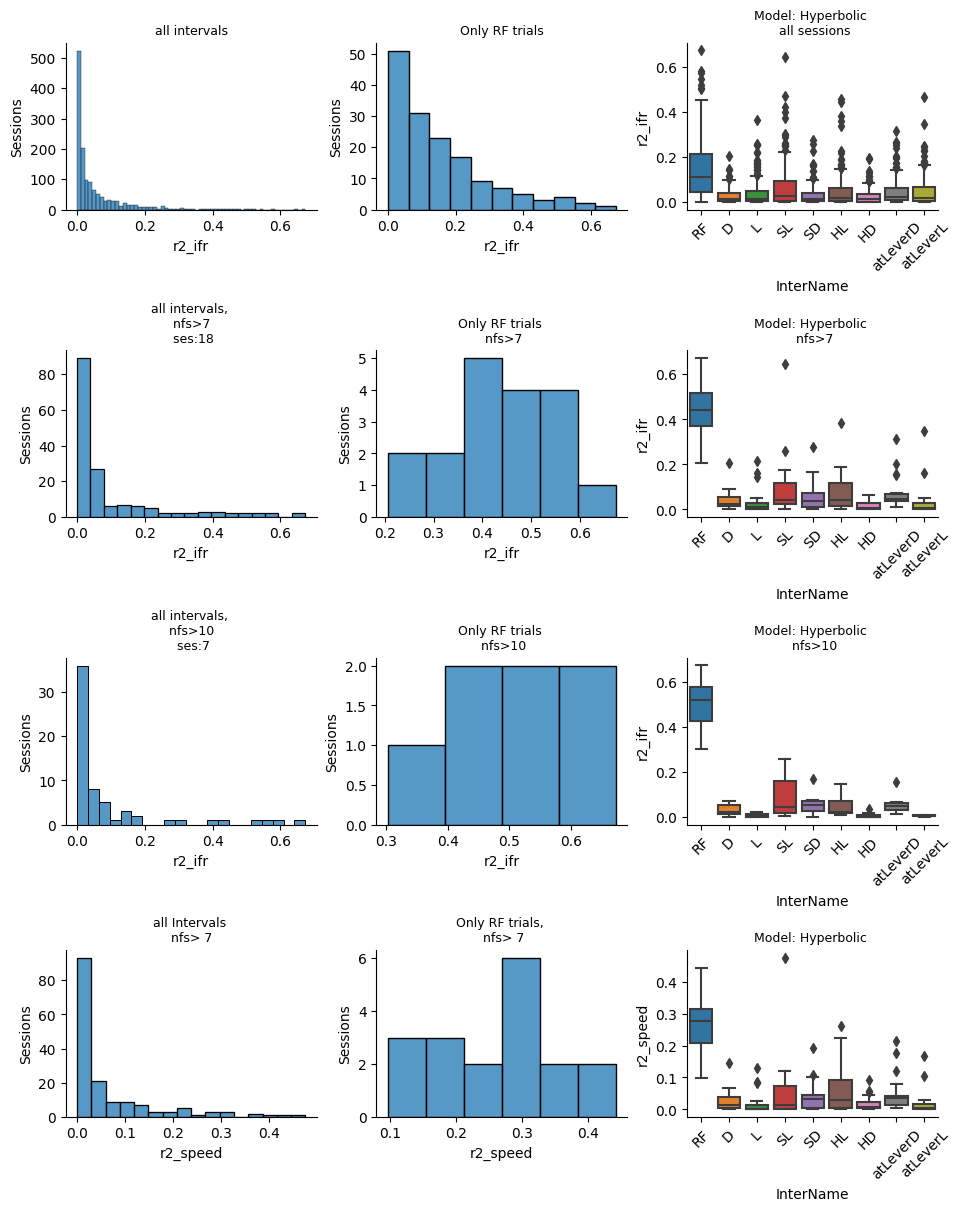

In [283]:
col = 4
row = 4
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)



ax= fig.add_subplot(gs[0,0])
sns.histplot(data= df, x= 'r2_ifr')
#xlabs= ['RF', 'D', 'L', 'SL', 'SD', 'HL', 'HD', 'atLeverD', 'atLeverL']
#ax.set_xticks(ticks=plt.gca().get_xticks(), labels=xlabs, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('r2_ifr')
ax.set_ylabel('Sessions')
ax.set_title('all intervals', fontsize= 9)

ax= fig.add_subplot(gs[0,1])
sns.histplot(data= df[(df.interName == 'circ80_1') & (df.nfs!= 0)], x= 'r2_ifr')
#xlabs= ['RF', 'D', 'L', 'SL', 'SD', 'HL', 'HD', 'atLeverD', 'atLeverL']
#ax.set_xticks(ticks=plt.gca().get_xticks(), labels=xlabs, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('r2_ifr')
ax.set_ylabel('Sessions')
ax.set_title('Only RF trials', fontsize= 9)

ax= fig.add_subplot(gs[0,2])
sns.boxplot(data= df, x='interName', y= 'r2_ifr')
xlabs= ['RF', 'D', 'L', 'SL', 'SD', 'HL', 'HD', 'atLeverD', 'atLeverL']
ax.set_xticks(ticks=plt.gca().get_xticks(), labels=xlabs, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('InterName')
ax.set_ylabel('r2_ifr')
ax.set_title('Model: Hyperbolic \n all sessions', fontsize= 9)

################################
###############
### nfs> 7
###################
ax= fig.add_subplot(gs[1,0])
sns.histplot(data= df[df.nfs>7], x= 'r2_ifr')
FS = cells[(cells.interneuron) & (cells.mrate_RF1 > 10)]
interneuron_counts = FS.groupby('session').cluId.count()
sessions_counts= interneuron_counts[interneuron_counts > 7]

# Step 4: Count how many sessions meet the condition
num_sessions = len(sessions_counts)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('r2_ifr')
ax.set_ylabel('Sessions')
ax.set_title(f'all intervals, \n nfs>7 \n ses:{num_sessions}', fontsize= 9)

ax= fig.add_subplot(gs[1,1])
sns.histplot(data= df[(df.interName == 'circ80_1') & (df.nfs>7)], x= 'r2_ifr')
#xlabs= ['RF', 'D', 'L', 'SL', 'SD', 'HL', 'HD', 'atLeverD', 'atLeverL']
#ax.set_xticks(ticks=plt.gca().get_xticks(), labels=xlabs, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('r2_ifr')
ax.set_ylabel('Sessions')
ax.set_title('Only RF trials \n nfs>7', fontsize= 9)

ax= fig.add_subplot(gs[1,2])
sns.boxplot(data= df[df.nfs>7], x='interName', y= 'r2_ifr')
xlabs= ['RF', 'D', 'L', 'SL', 'SD', 'HL', 'HD', 'atLeverD', 'atLeverL']
ax.set_xticks(ticks=plt.gca().get_xticks(), labels=xlabs, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('InterName')
ax.set_ylabel('r2_ifr')
ax.set_title('Model: Hyperbolic \n nfs>7', fontsize= 9)


################################
###############
### nfs> 10
###################
ax= fig.add_subplot(gs[2,0])
sns.histplot(data= df[df.nfs>10], x= 'r2_ifr')
FS = cells[(cells.interneuron) & (cells.mrate_RF1 > 10)]
interneuron_counts = FS.groupby('session').cluId.count()
sessions_counts= interneuron_counts[interneuron_counts > 10]

# Step 4: Count how many sessions meet the condition
num_sessions = len(sessions_counts)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('r2_ifr')
ax.set_ylabel('Sessions')
ax.set_title(f'all intervals, \n nfs>10 \n ses:{num_sessions}', fontsize= 9)

ax= fig.add_subplot(gs[2,1])
sns.histplot(data= df[(df.interName == 'circ80_1') & (df.nfs>10)], x= 'r2_ifr')
#xlabs= ['RF', 'D', 'L', 'SL', 'SD', 'HL', 'HD', 'atLeverD', 'atLeverL']
#ax.set_xticks(ticks=plt.gca().get_xticks(), labels=xlabs, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('r2_ifr')
ax.set_ylabel('Sessions')
ax.set_title('Only RF trials \n nfs>10', fontsize= 9)

ax= fig.add_subplot(gs[2,2])
sns.boxplot(data= df[df.nfs>10], x='interName', y= 'r2_ifr')
xlabs= ['RF', 'D', 'L', 'SL', 'SD', 'HL', 'HD', 'atLeverD', 'atLeverL']
ax.set_xticks(ticks=plt.gca().get_xticks(), labels=xlabs, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('InterName')
ax.set_ylabel('r2_ifr')
ax.set_title('Model: Hyperbolic \n nfs>10', fontsize= 9)



#############
#### Predicting speed
##############
ax= fig.add_subplot(gs[3,0])
sns.histplot(data= df[(df.nfs> 7)], x= 'r2_speed')
#xlabs= ['RF', 'D', 'L', 'SL', 'SD', 'HL', 'HD', 'atLeverD', 'atLeverL']
#ax.set_xticks(ticks=plt.gca().get_xticks(), labels=xlabs, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('r2_speed')
ax.set_ylabel('Sessions')
ax.set_title('all Intervals \n nfs> 7 ', fontsize= 9)

ax= fig.add_subplot(gs[3,1])
sns.histplot(data= df[(df.interName == 'circ80_1') & (df.nfs>7)], x= 'r2_speed')
#xlabs= ['RF', 'D', 'L', 'SL', 'SD', 'HL', 'HD', 'atLeverD', 'atLeverL']
#ax.set_xticks(ticks=plt.gca().get_xticks(), labels=xlabs, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('r2_speed')
ax.set_ylabel('Sessions')
ax.set_title('Only RF trials, \n nfs> 7', fontsize= 9)


ax= fig.add_subplot(gs[3,2])
sns.boxplot(data= df[(df.nfs>7)], x='interName', y= 'r2_speed')
xlabs= ['RF', 'D', 'L', 'SL', 'SD', 'HL', 'HD', 'atLeverD', 'atLeverL']
ax.set_xticks(ticks=plt.gca().get_xticks(), labels=xlabs, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('InterName')
ax.set_ylabel('r2_speed')
ax.set_title('Model: Hyperbolic ', fontsize= 9)



In [276]:
# Step 1: Filter the DataFrame
FS = cells[(cells.interneuron) & (cells.mrate_RF1 > 10)]
interneuron_counts = FS.groupby('session').cluId.count()
sessions_counts= interneuron_counts[interneuron_counts > 7]

# Step 4: Count how many sessions meet the condition
num_sessions = len(sessions_counts)
print(f'Number of sessions with more than 7 FS: {num_sessions}')


Number of sessions with more than 7 FS: 18


In [275]:
df[(df.interName == 'circ80_1')& (df.nfs>7)].r2_ifr.mean(), df[(df.interName == 'circ80_1') & (df.nfs>7)].r2_speed.mean()

(0.43576981971423645, 0.26659791491383783)

What does R² represent?

    R² = 1: The model perfectly explains all the variance in the data.
    R² = 0: The model does not explain any of the variance (i.e., the predictions are no better than the mean of the dependent variable).
    
* We can explain around 43% percent of the variance in the ifr from the hyperbolic model in the RF trials in sessions that we have more than 7 FS 
* We can only explain the 26% percent of the variance in the speed of the animal from the hyperbolic model in RF trials 

In [279]:
# Step 1: Filter the DataFrame
FS = cells[(cells.interneuron) & (cells.mrate_RF1 > 10)]
interneuron_counts = FS.groupby('session').cluId.count()
sessions_counts= interneuron_counts[interneuron_counts > 10]

# Step 4: Count how many sessions meet the condition
num_sessions = len(sessions_counts)
print(f'Number of sessions with more than 10 FS: {num_sessions}')


Number of sessions with more than 10 FS: 7


In [ ]:
With the random forest model we could 